In [4]:
!mamba install geopandas
!mamba install pandas
!mamba install libpysal
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, box, Point
import matplotlib.colors as colors
import warnings
warnings.filterwarnings('ignore')

mambajs 0.19.13

Specs: xeus-python, numpy, matplotlib, pillow, ipywidgets>=8.1.6, ipyleaflet, scipy, pandas, geopandas, libpysal
Channels: emscripten-forge, conda-forge

Solving environment...
Solving took 1.4115 seconds
All requested packages already installed.
mambajs 0.19.13

Specs: xeus-python, numpy, matplotlib, pillow, ipywidgets>=8.1.6, ipyleaflet, scipy, pandas, geopandas, libpysal
Channels: emscripten-forge, conda-forge

Solving environment...
Solving took 1.2467000000476838 seconds
All requested packages already installed.
mambajs 0.19.13

Specs: xeus-python, numpy, matplotlib, pillow, ipywidgets>=8.1.6, ipyleaflet, scipy, pandas, geopandas, libpysal
Channels: emscripten-forge, conda-forge

Solving environment...
Solving took 1.0817999999523162 seconds
All requested packages already installed.


In [5]:
# 1. СОЗДАНИЕ СИНТЕТИЧЕСКИХ ДАННЫХ

print("="*80)
print("ЗАДАНИЕ 8: ПРОСТРАНСТВЕННАЯ АВТОКОРРЕЛЯЦИЯ")
print("="*80)

np.random.seed(42)
n_rows, n_cols = 8, 8  # сетка 8x8 районов (64 района)
n_regions = n_rows * n_cols

# Создаём сетку районов
cells = []
for i in range(n_rows):
    for j in range(n_cols):
        # Полигон района (каждый размером 10x10)
        poly = Polygon([
            (j*10, i*10),
            ((j+1)*10, i*10),
            ((j+1)*10, (i+1)*10),
            (j*10, (i+1)*10)
        ])
        cells.append(poly)

# Создаём значения с чёткой пространственной структурой
# Центр (районы 3-5, 3-5) - высокие значения
# Периферия - низкие значения
values = np.zeros(n_regions)
idx = 0
for i in range(n_rows):
    for j in range(n_cols):
        # Расстояние от центра (3.5, 3.5) - центр сетки
        center_dist = np.sqrt((i - 3.5)**2 + (j - 3.5)**2)
        
        if center_dist < 2.0:
            # Центр - высокие значения
            values[idx] = 90 + np.random.normal(0, 5)
        elif center_dist < 3.5:
            # Средняя зона - средние значения
            values[idx] = 60 + np.random.normal(0, 8)
        else:
            # Периферия - низкие значения
            values[idx] = 30 + np.random.normal(0, 10)
        
        # Добавляем один "горячий" район на периферии (аномалия)
        if i == 0 and j == 7:  # дальний угол
            values[idx] = 85
            
        # Добавляем один "холодный" район в центре (аномалия)
        if i == 4 and j == 4:  # центр
            values[idx] = 45
            
        idx += 1

# Создаём GeoDataFrame
gdf = gpd.GeoDataFrame({
    'region_id': range(1, n_regions+1),
    'value': values,
    'row': [i for i in range(n_rows) for _ in range(n_cols)],
    'col': [j for _ in range(n_rows) for j in range(n_cols)],
    'geometry': cells
}, crs="EPSG:3857")

print(f"\n ДАННЫЕ:")
print(f"   Количество районов: {len(gdf)}")
print(f"   Минимальное значение: {gdf['value'].min():.1f}")
print(f"   Максимальное значение: {gdf['value'].max():.1f}")
print(f"   Среднее значение: {gdf['value'].mean():.1f}")
print(f"   Стандартное отклонение: {gdf['value'].std():.1f}")

ЗАДАНИЕ 8: ПРОСТРАНСТВЕННАЯ АВТОКОРРЕЛЯЦИЯ

 ДАННЫЕ:
   Количество районов: 64
   Минимальное значение: 12.4
   Максимальное значение: 97.3
   Среднее значение: 49.4
   Стандартное отклонение: 23.1


In [6]:
# 2. СОЗДАНИЕ ВЕСОВОЙ МАТРИЦЫ ВРУЧНУЮ

print("\n" + "="*80)
print("СОЗДАНИЕ ВЕСОВОЙ МАТРИЦЫ (QUEEN CONTIGUITY)")
print("="*80)

# Создаём весовую матрицу вручную (без libpysal)
n = len(gdf)
weights = np.zeros((n, n))

for i in range(n):
    row_i = gdf.iloc[i]['row']
    col_i = gdf.iloc[i]['col']
    
    for j in range(n):
        if i == j:
            continue
            
        row_j = gdf.iloc[j]['row']
        col_j = gdf.iloc[j]['col']
        
        # Проверяем соседство по Queen (включая диагонали)
        row_diff = abs(row_i - row_j)
        col_diff = abs(col_i - col_j)
        
        if row_diff <= 1 and col_diff <= 1 and not (row_diff == 0 and col_diff == 0):
            weights[i, j] = 1

# Нормализация строк (row-standardization)
row_sums = weights.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1  # избегаем деления на ноль
weights_normalized = weights / row_sums

print(f"   Создана весовая матрица {n}x{n}")
print(f"   Среднее количество соседей: {weights.sum(axis=1).mean():.1f}")
print(f"   Минимум соседей: {weights.sum(axis=1).min():.0f}")
print(f"   Максимум соседей: {weights.sum(axis=1).max():.0f}")


СОЗДАНИЕ ВЕСОВОЙ МАТРИЦЫ (QUEEN CONTIGUITY)
   Создана весовая матрица 64x64
   Среднее количество соседей: 6.6
   Минимум соседей: 3
   Максимум соседей: 8


In [7]:
# 3. РАСЧЁТ ГЛОБАЛЬНОГО MORAN'S I ВРУЧНУЮ

print("\n" + "="*80)
print("РАСЧЁТ ГЛОБАЛЬНОГО MORAN'S I")
print("="*80)

# Функция для расчёта Moran's I
def calculate_moran_i(values, weights):
    """
    Ручной расчёт глобального Moran's I
    """
    n = len(values)
    y = values - np.mean(values)
    y_bar = np.mean(values)
    
    # Знаменатель: сумма квадратов отклонений
    s2 = np.sum(y**2) / n
    
    # Числитель: пространственная автоковариация
    numerator = 0
    for i in range(n):
        for j in range(n):
            if weights[i, j] > 0:
                numerator += weights[i, j] * y[i] * y[j]
    
    # Сумма всех весов
    s0 = np.sum(weights)
    
    # Moran's I
    moran_i = (n / s0) * (numerator / np.sum(y**2))
    
    return moran_i

# Расчёт наблюдаемого Moran's I
moran_i_observed = calculate_moran_i(gdf['value'].values, weights_normalized)

print(f"\n НАБЛЮДАЕМЫЙ MORAN'S I:")
print(f"   I = {moran_i_observed:.4f}")


РАСЧЁТ ГЛОБАЛЬНОГО MORAN'S I

 НАБЛЮДАЕМЫЙ MORAN'S I:
   I = 0.4356


In [8]:
# 4. ПРОВЕРКА ЗНАЧИМОСТИ (ПЕРЕСТАНОВОЧНЫЙ ТЕСТ)

print("\n" + "="*80)
print("ПРОВЕРКА СТАТИСТИЧЕСКОЙ ЗНАЧИМОСТИ")
print("="*80)

n_permutations = 999
values_array = gdf['value'].values
random_ips = []

for perm in range(n_permutations):
    # Перемешиваем значения
    shuffled = np.random.permutation(values_array)
    # Считаем Moran's I для перемешанных данных
    moran_i_rand = calculate_moran_i(shuffled, weights_normalized)
    random_ips.append(moran_i_rand)

# Расчёт псевдо-p-value
random_ips = np.array(random_ips)
p_value = (np.sum(random_ips >= moran_i_observed) + 1) / (n_permutations + 1)

print(f"\n РЕЗУЛЬТАТЫ ТЕСТА:")
print(f"   Наблюдаемый Moran's I: {moran_i_observed:.4f}")
print(f"   Среднее случайное I: {random_ips.mean():.4f}")
print(f"   Стандартное отклонение: {random_ips.std():.4f}")
print(f"   p-value: {p_value:.4f}")
print(f"   Ожидаемое I при случайности: {-1/(n-1):.4f}")

if p_value < 0.05:
    print("    Статистически значимая пространственная автокорреляция (p < 0.05)")
else:
    print("    Недостаточно доказательств пространственной автокорреляции")


ПРОВЕРКА СТАТИСТИЧЕСКОЙ ЗНАЧИМОСТИ

 РЕЗУЛЬТАТЫ ТЕСТА:
   Наблюдаемый Moran's I: 0.4356
   Среднее случайное I: -0.0151
   Стандартное отклонение: 0.0660
   p-value: 0.0010
   Ожидаемое I при случайности: -0.0159
    Статистически значимая пространственная автокорреляция (p < 0.05)


In [9]:
# 5. РАСЧЁТ ЛОКАЛЬНОГО MORAN'S I (LISA) ВРУЧНУЮ

print("\n" + "="*80)
print("РАСЧЁТ ЛОКАЛЬНОГО MORAN'S I (LISA)")
print("="*80)

def calculate_local_moran(values, weights, i):
    """
    Расчёт локального Moran's I для i-го наблюдения
    """
    n = len(values)
    y = values - np.mean(values)
    
    # Знаменатель: дисперсия
    s2 = np.sum(y**2) / n
    
    # Числитель: вклад соседей
    neighbors_sum = 0
    for j in range(n):
        if weights[i, j] > 0:
            neighbors_sum += weights[i, j] * y[j]
    
    # Локальный Moran's I
    local_i = (y[i] / s2) * neighbors_sum
    
    return local_i

# Расчёт локального Moran's I для всех наблюдений
local_i_values = []
for i in range(n):
    local_i = calculate_local_moran(gdf['value'].values, weights_normalized, i)
    local_i_values.append(local_i)

gdf['local_i'] = local_i_values

print(f"\n ЛОКАЛЬНЫЙ MORAN'S I:")
print(f"   Минимальный: {gdf['local_i'].min():.4f}")
print(f"   Максимальный: {gdf['local_i'].max():.4f}")
print(f"   Средний: {gdf['local_i'].mean():.4f}")


РАСЧЁТ ЛОКАЛЬНОГО MORAN'S I (LISA)

 ЛОКАЛЬНЫЙ MORAN'S I:
   Минимальный: -1.4789
   Максимальный: 2.3526
   Средний: 0.4356


In [10]:
# 6. ОПРЕДЕЛЕНИЕ ТИПОВ КЛАСТЕРОВ

print("\n" + "="*80)
print("ОПРЕДЕЛЕНИЕ ТИПОВ ПРОСТРАНСТВЕННЫХ КЛАСТЕРОВ")
print("="*80)

# Нормализованные значения для классификации
mean_val = gdf['value'].mean()
std_val = gdf['value'].std()

# Классификация по квадрантам
# Quadrant: 1=HH, 2=LH, 3=LL, 4=HL
gdf['quadrant'] = 0  # незначимый

for i in range(n):
    # Центрированные значения
    y_i = gdf.loc[i, 'value'] - mean_val
    # Взвешенное среднее соседей (spatial lag)
    neighbors_sum = 0
    for j in range(n):
        if weights_normalized[i, j] > 0:
            neighbors_sum += weights_normalized[i, j] * (gdf.loc[j, 'value'] - mean_val)
    
    # Определение квадранта
    if y_i > 0 and neighbors_sum > 0:
        gdf.loc[i, 'quadrant'] = 1  # High-High
    elif y_i < 0 and neighbors_sum > 0:
        gdf.loc[i, 'quadrant'] = 2  # Low-High
    elif y_i < 0 and neighbors_sum < 0:
        gdf.loc[i, 'quadrant'] = 3  # Low-Low
    elif y_i > 0 and neighbors_sum < 0:
        gdf.loc[i, 'quadrant'] = 4  # High-Low

# Добавляем информацию о значимости (упрощённо)
# Считаем значимыми районы с |local_i| > 1.96 * std
local_i_std = gdf['local_i'].std()
gdf['significant'] = np.abs(gdf['local_i']) > 1.5 * local_i_std

# Создаём метки для карты
gdf['lisa_cluster'] = 'Not Significant'
gdf.loc[(gdf['quadrant'] == 1) & (gdf['significant']), 'lisa_cluster'] = 'High-High'
gdf.loc[(gdf['quadrant'] == 2) & (gdf['significant']), 'lisa_cluster'] = 'Low-High'
gdf.loc[(gdf['quadrant'] == 3) & (gdf['significant']), 'lisa_cluster'] = 'Low-Low'
gdf.loc[(gdf['quadrant'] == 4) & (gdf['significant']), 'lisa_cluster'] = 'High-Low'

print(f"\n РАСПРЕДЕЛЕНИЕ КЛАСТЕРОВ:")
print(f"   High-High: {sum(gdf['lisa_cluster'] == 'High-High')} районов")
print(f"   Low-Low: {sum(gdf['lisa_cluster'] == 'Low-Low')} районов")
print(f"   Low-High: {sum(gdf['lisa_cluster'] == 'Low-High')} районов")
print(f"   High-Low: {sum(gdf['lisa_cluster'] == 'High-Low')} районов")
print(f"   Не значимо: {sum(gdf['lisa_cluster'] == 'Not Significant')} районов")


ОПРЕДЕЛЕНИЕ ТИПОВ ПРОСТРАНСТВЕННЫХ КЛАСТЕРОВ

 РАСПРЕДЕЛЕНИЕ КЛАСТЕРОВ:
   High-High: 10 районов
   Low-Low: 1 районов
   Low-High: 0 районов
   High-Low: 1 районов
   Не значимо: 52 районов



ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ


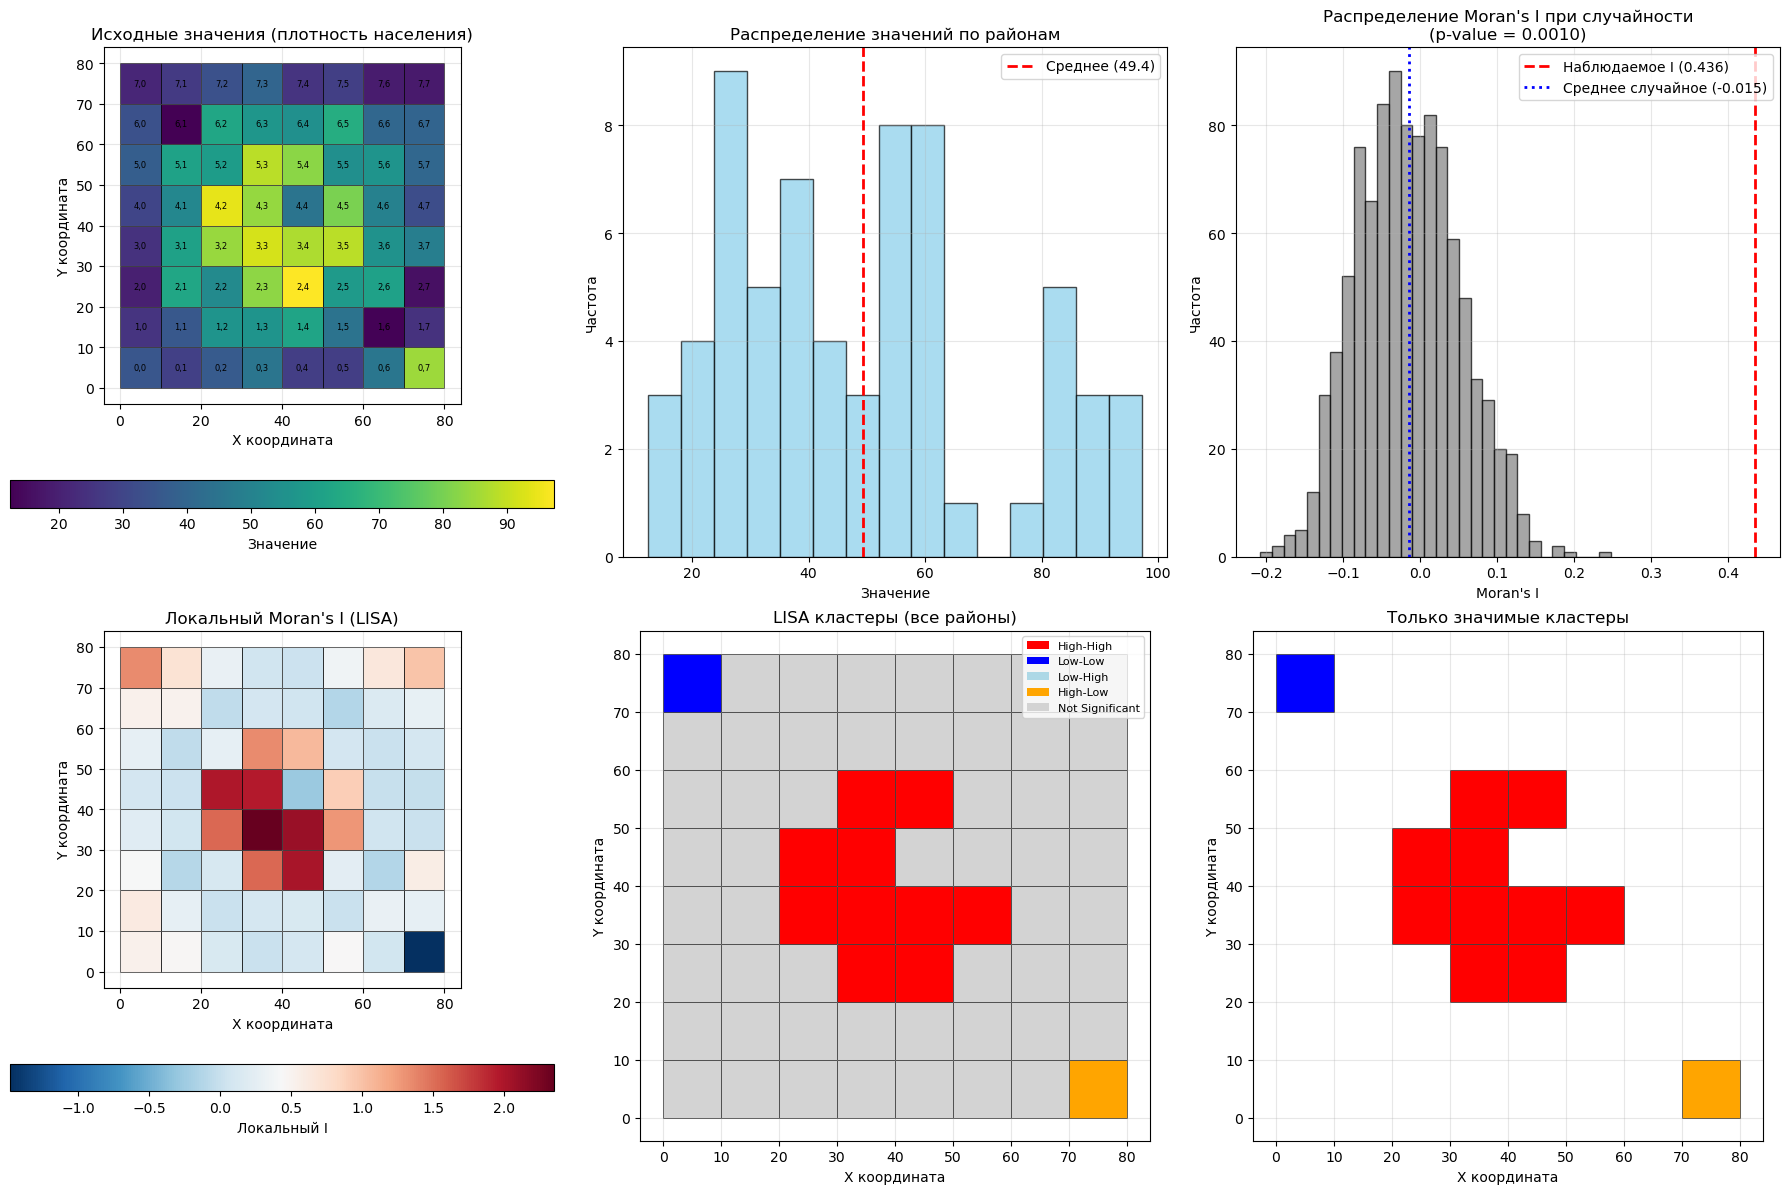

In [11]:
# 7. ВИЗУАЛИЗАЦИЯ

print("\n" + "="*80)
print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Исходные значения
ax = axes[0, 0]
gdf.plot(column='value', ax=ax, legend=True, 
         cmap='viridis', edgecolor='black', linewidth=0.5,
         legend_kwds={'label': 'Значение', 'orientation': 'horizontal'})
ax.set_title('Исходные значения (плотность населения)', fontsize=12)
ax.set_xlabel('X координата')
ax.set_ylabel('Y координата')
ax.grid(True, alpha=0.3)

# Добавляем номера районов для справки
for idx, row in gdf.iterrows():
    ax.text(row.geometry.centroid.x, row.geometry.centroid.y, 
            f"{row['row']},{row['col']}", 
            fontsize=6, ha='center', va='center')

# 2. Распределение значений (гистограмма)
ax = axes[0, 1]
ax.hist(gdf['value'], bins=15, color='skyblue', edgecolor='black', alpha=0.7)
ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Среднее ({mean_val:.1f})')
ax.set_xlabel('Значение')
ax.set_ylabel('Частота')
ax.set_title('Распределение значений по районам')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Гистограмма случайных Moran's I
ax = axes[0, 2]
ax.hist(random_ips, bins=30, color='gray', edgecolor='black', alpha=0.7)
ax.axvline(moran_i_observed, color='red', linestyle='--', linewidth=2, 
           label=f'Наблюдаемое I ({moran_i_observed:.3f})')
ax.axvline(random_ips.mean(), color='blue', linestyle=':', linewidth=2,
           label=f'Среднее случайное ({random_ips.mean():.3f})')
ax.set_xlabel('Moran\'s I')
ax.set_ylabel('Частота')
ax.set_title(f'Распределение Moran\'s I при случайности\n(p-value = {p_value:.4f})')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Локальный Moran's I
ax = axes[1, 0]
gdf.plot(column='local_i', ax=ax, legend=True, 
         cmap='RdBu_r', edgecolor='black', linewidth=0.5,
         legend_kwds={'label': 'Локальный I', 'orientation': 'horizontal'})
ax.set_title('Локальный Moran\'s I (LISA)', fontsize=12)
ax.set_xlabel('X координата')
ax.set_ylabel('Y координата')
ax.grid(True, alpha=0.3)

# 5. Кластеры LISA (все)
ax = axes[1, 1]
cluster_colors = {
    'High-High': 'red',
    'Low-Low': 'blue',
    'Low-High': 'lightblue',
    'High-Low': 'orange',
    'Not Significant': 'lightgray'
}
gdf.plot(ax=ax, color=[cluster_colors[c] for c in gdf['lisa_cluster']],
         edgecolor='black', linewidth=0.5)
ax.set_title('LISA кластеры (все районы)', fontsize=12)
ax.set_xlabel('X координата')
ax.set_ylabel('Y координата')
ax.grid(True, alpha=0.3)

# Легенда для кластеров
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=label) 
                   for label, color in cluster_colors.items()]
ax.legend(handles=legend_elements, loc='upper right', fontsize=8)

# 6. Только значимые кластеры
ax = axes[1, 2]
significant_mask = gdf['significant']
if significant_mask.any():
    gdf[significant_mask].plot(ax=ax, 
                               color=[cluster_colors[c] for c in gdf[significant_mask]['lisa_cluster']],
                               edgecolor='black', linewidth=0.5)
else:
    ax.text(0.5, 0.5, 'Нет значимых кластеров', ha='center', va='center')
ax.set_title('Только значимые кластеры', fontsize=12)
ax.set_xlabel('X координата')
ax.set_ylabel('Y координата')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


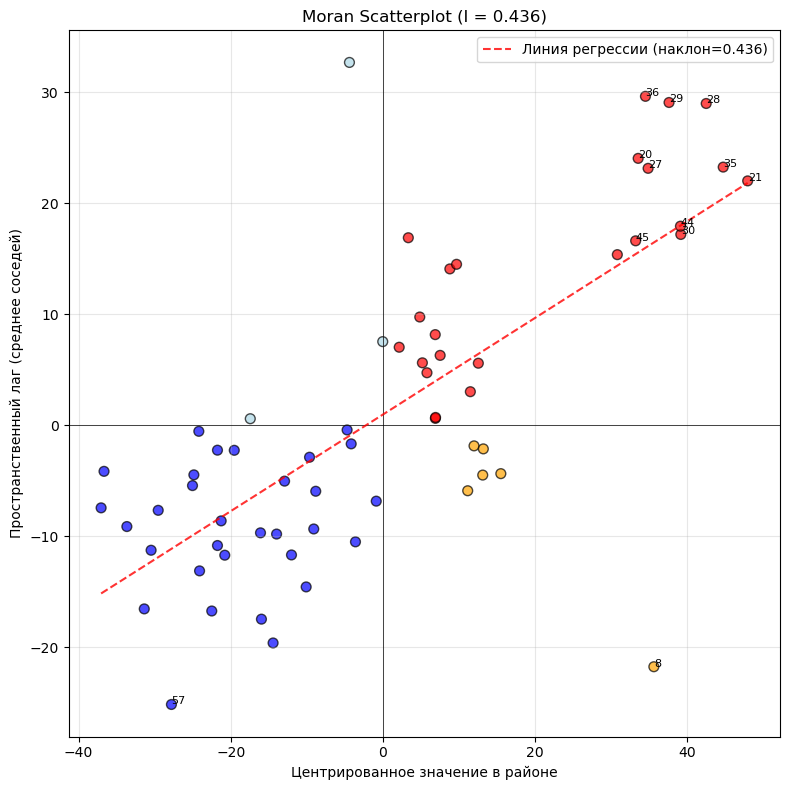

In [12]:
# 8. Scatter plot (Moran scatterplot)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Рассчитываем spatial lag (взвешенное среднее соседей)
spatial_lag = np.zeros(n)
for i in range(n):
    for j in range(n):
        if weights_normalized[i, j] > 0:
            spatial_lag[i] += weights_normalized[i, j] * gdf.loc[j, 'value']

# Центрируем значения
y_centered = gdf['value'] - mean_val
lag_centered = spatial_lag - mean_val

# Цвета для квадрантов
colors_scatter = []
for i in range(n):
    if y_centered.iloc[i] > 0 and lag_centered[i] > 0:
        colors_scatter.append('red')    # HH
    elif y_centered.iloc[i] < 0 and lag_centered[i] < 0:
        colors_scatter.append('blue')   # LL
    elif y_centered.iloc[i] < 0 and lag_centered[i] > 0:
        colors_scatter.append('lightblue')  # LH
    else:
        colors_scatter.append('orange')     # HL

# Рисуем scatter plot
ax.scatter(y_centered, lag_centered, c=colors_scatter, alpha=0.7, s=50, edgecolor='black')

# Линии регрессии и средние
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

# Линия регрессии
z = np.polyfit(y_centered, lag_centered, 1)
p = np.poly1d(z)
x_line = np.linspace(y_centered.min(), y_centered.max(), 100)
ax.plot(x_line, p(x_line), "r--", alpha=0.8, label=f'Линия регрессии (наклон={z[0]:.3f})')

ax.set_xlabel('Центрированное значение в районе')
ax.set_ylabel('Пространственный лаг (среднее соседей)')
ax.set_title(f'Moran Scatterplot (I = {moran_i_observed:.3f})')
ax.legend()
ax.grid(True, alpha=0.3)

# Добавляем подписи для точек
for i, txt in enumerate(gdf['region_id']):
    if significant_mask.iloc[i]:
        ax.annotate(f'{txt}', (y_centered.iloc[i], lag_centered[i]), fontsize=8)

plt.tight_layout()
plt.show()
